In [14]:
from dataset import *
import sys
import os

# Parameters

In [15]:
data_path = '/Users/tenboker/Desktop/Code Shtuff/FRITZ/yartsev/bat/data' # Replace this
bat_id = '32622'
date =  '231007'


# Load data

In [16]:
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

Loading Flight Room | 32622 | 231007 from cache...


# Some dataset basics

In this dataset we have 1 bat with 2 Neuropixel probes implanted in dorsal CA1 and CA3 hippocampus (unilaterally). For the experiment task, the bat is trained to forage from 2 automated feeders in a large room where the bat is allowed to fly freely. We track the bat's position using a system called Cortex. 

Behaviorally, bats naturally form stereotyped trajectories between their preferred perch location and the feeders. We can see this by plotting their X and Y position in the room during the recording

In [17]:
pos = session.cortex_data.bat_pos # (num_timepoints, XYZ)
pos.shape
pos[:,1]

array([nan, nan, nan, ..., nan, nan, nan])

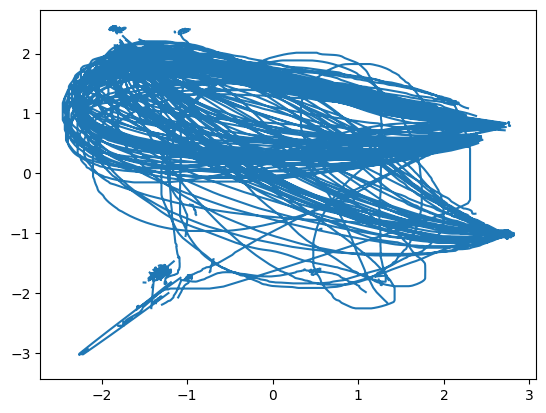

In [18]:
plt.plot(pos[:,0], pos[:,1]) # Feeder location are the 2 cusps on the right

In [19]:
from helpers_bat import *
cleaned_pos = np.copy(pos)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])

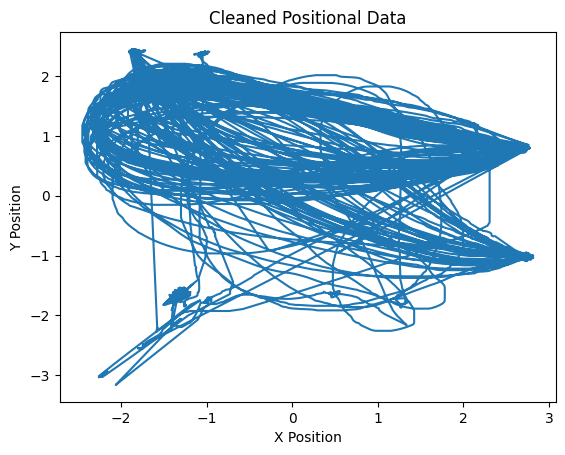

In [20]:
# Plot the cleaned positional data
plt.plot(cleaned_pos[:, 0], cleaned_pos[:, 1])
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Cleaned Positional Data')
plt.show()

Because the bat forms these stereotyped trajectories, we can naturally cluster their flights into discrete sets. 
Cluster 1 flights are all the unstructured flights; flights that do not follow a predictable path.
Clusters 2 and onwards (structured; more repeated flight paths) are the clusters sorted in descending order by the number of flights in each cluster. 
You can access these clusters via:

In [ ]:
session

In [ ]:
cluster_2_flights = session.get_flights_by_cluster((2,)) # List of all cluster 2 flights
cluster_2_and_3_flights = session.get_flights_by_cluster((2,3)) # List of all cluster 2 and 3 flights

cluster_2_flights[0].__dict__ # You can access the start and end of the flights and other information



# Visualizing the flight paths
We can visualize the flight paths in 3D by cluster. We will notice that there are two feeder locations on the left and right of the same wall, with a perch in the corner of the opposite wall. The directionality and timing of these flight paths are clearer with the annotated clusters below.

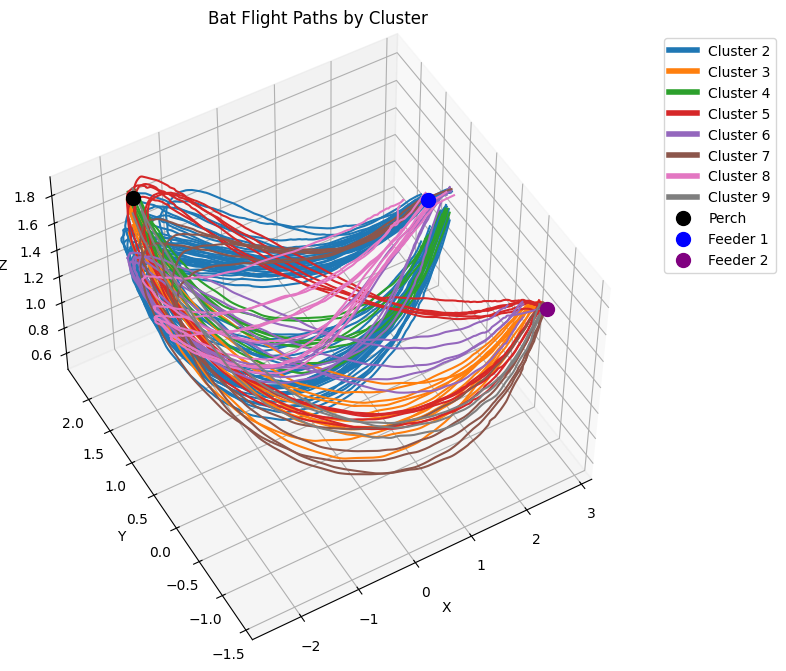

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.colors as mcolors

# Assuming `session` is already defined and contains the flight data

# Get all clusters as a list of integers and sort them, excluding cluster 1
all_clusters = sorted([int(cluster_id) for cluster_id in session.flights_by_cluster.keys() if int(cluster_id) != 1])

# Separate cluster 1 flights
cluster_1_flights = session.get_flights_by_cluster([1])

# Create a colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Lists to store ending positions
perch_positions = []
feeder_1_positions = []
feeder_2_positions = []

# Plot 3D flight paths with different colors for each cluster (excluding cluster 1)
fig = plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
ax = fig.add_subplot(111, projection='3d')

# Create a dictionary to store labels for the legend
labels = {}

for idx, cluster_id in enumerate(all_clusters):
    cluster_flights = session.get_flights_by_cluster([cluster_id])
    for flight in cluster_flights:
        start_idx, end_idx = flight.timebin_start_idx, flight.timebin_end_idx
        color = colors[idx % len(colors)]
        ax.plot(pos[start_idx:end_idx, 0], pos[start_idx:end_idx, 1], pos[start_idx:end_idx, 2], color=color)
        
        # Add the label for the legend only once per cluster
        if cluster_id not in labels:
            labels[cluster_id] = color
        
        # Collect ending positions
        end_position = pos[end_idx - 1]  # Get the last position of the flight
        if end_position[1] > 0 and end_position[0] < 0:
            perch_positions.append(end_position)
        elif end_position[1] > 0 and end_position[0] > 0:
            feeder_1_positions.append(end_position)
        elif end_position[1] < 0 and end_position[0] > 0:
            feeder_2_positions.append(end_position)

# Calculate average positions
perch_avg = np.mean(perch_positions, axis=0) if perch_positions else np.array([np.nan, np.nan, np.nan])
feeder_1_avg = np.mean(feeder_1_positions, axis=0) if feeder_1_positions else np.array([np.nan, np.nan, np.nan])
feeder_2_avg = np.mean(feeder_2_positions, axis=0) if feeder_2_positions else np.array([np.nan, np.nan, np.nan])

# Plot average positions for perch and feeders
ax.scatter(perch_avg[0], perch_avg[1], perch_avg[2], color='black', marker='o', s=100, label='Perch')
ax.scatter(feeder_1_avg[0], feeder_1_avg[1], feeder_1_avg[2], color='blue', marker='o', s=100, label='Feeder 1')
ax.scatter(feeder_2_avg[0], feeder_2_avg[1], feeder_2_avg[2], color='purple', marker='o', s=100, label='Feeder 2')

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('Bat Flight Paths by Cluster')

# Create a legend
legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=f'Cluster {cluster_id}')
                  for cluster_id, color in labels.items()]
legend_handles.append(plt.Line2D([0], [0], color='black', marker='o', markersize=10, label='Perch', linestyle=''))
legend_handles.append(plt.Line2D([0], [0], color='blue', marker='o', markersize=10, label='Feeder 1', linestyle=''))
legend_handles.append(plt.Line2D([0], [0], color='purple', marker='o', markersize=10, label='Feeder 2', linestyle=''))

ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.view_init(elev=50, azim=-120)  # Adjust the elevation and azimuth angle as needed

# Show the plot
plt.show()


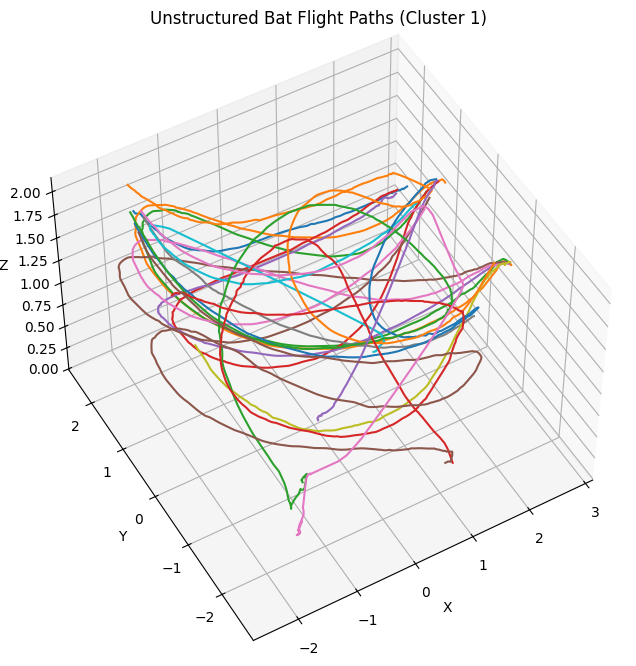

In [22]:
# Plot 3D flight paths for cluster 1, color-coded by individual flights

# Separate cluster 1 flights
cluster_1_flights = session.get_flights_by_cluster([1])

fig_cluster_1 = plt.figure(figsize=(14, 8))
ax_cluster_1 = fig_cluster_1.add_subplot(111, projection='3d')

for idx, flight in enumerate(cluster_1_flights):
    start_idx, end_idx = flight.timebin_start_idx, flight.timebin_end_idx
    color = colors[idx % len(colors)]
    ax_cluster_1.plot(pos[start_idx:end_idx, 0], pos[start_idx:end_idx, 1], pos[start_idx:end_idx, 2], color=color)

# Set labels for each axis
ax_cluster_1.set_xlabel('X')
ax_cluster_1.set_ylabel('Y')
ax_cluster_1.set_zlabel('Z')

# Set a title for the plot
ax_cluster_1.set_title('Unstructured Bat Flight Paths (Cluster 1)')

ax_cluster_1.view_init(elev=50,azim=-120)  # Adjust the elevation and azimuth angle as needed


# Show the plot
plt.show()

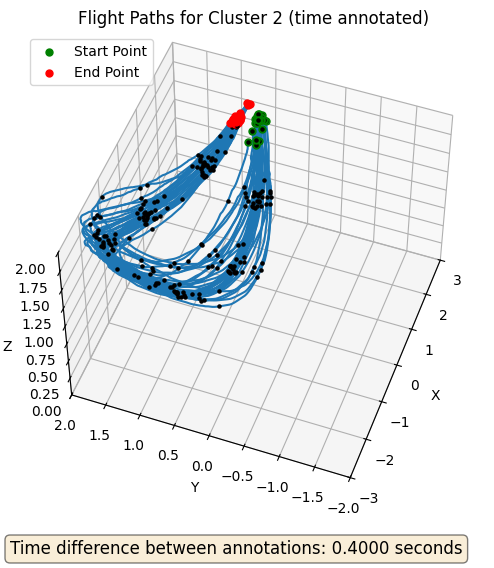

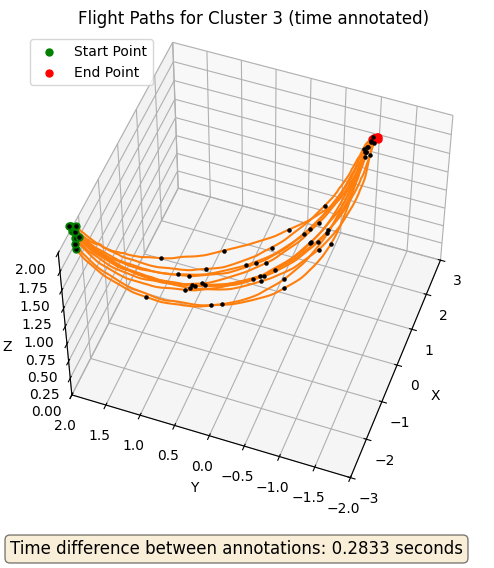

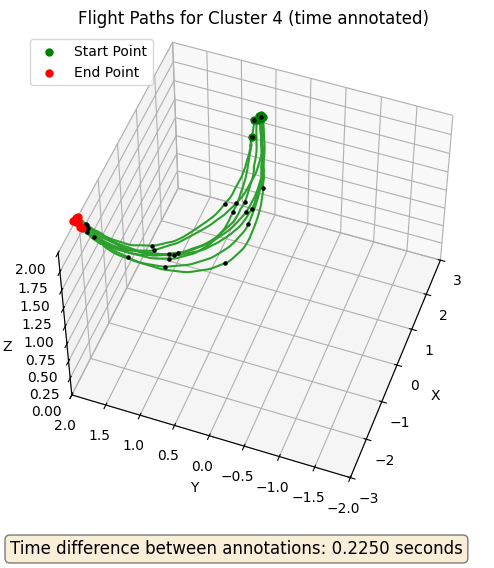

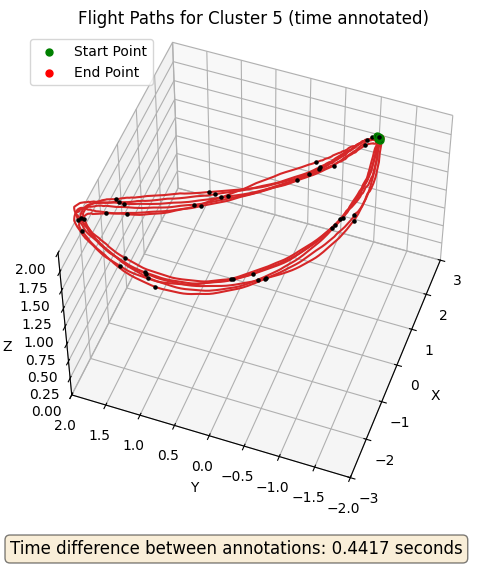

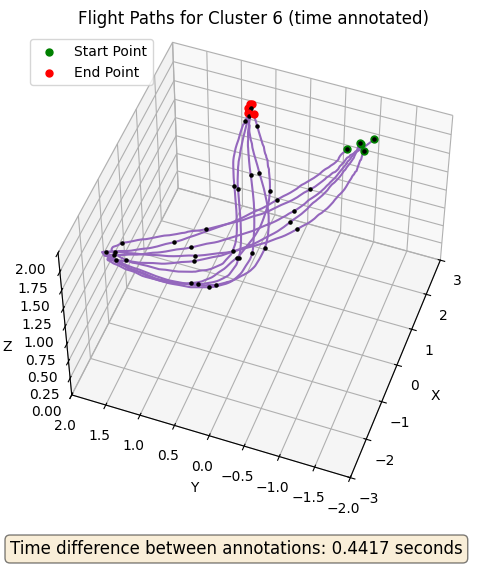

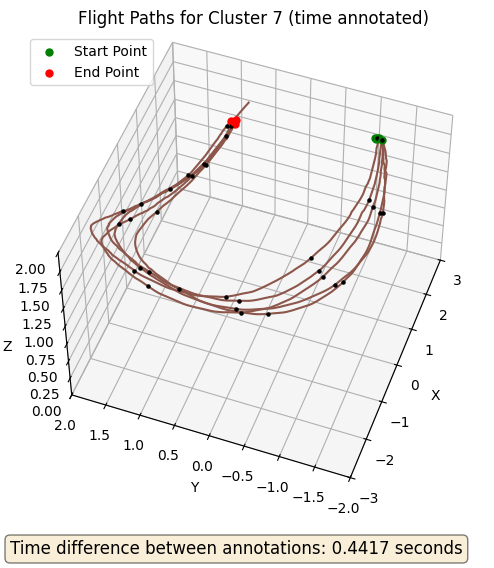

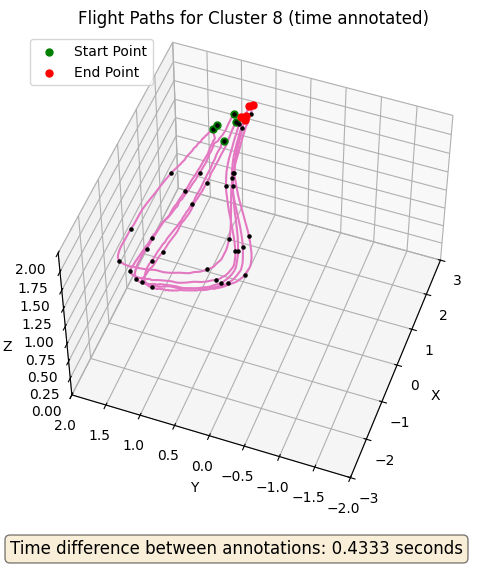

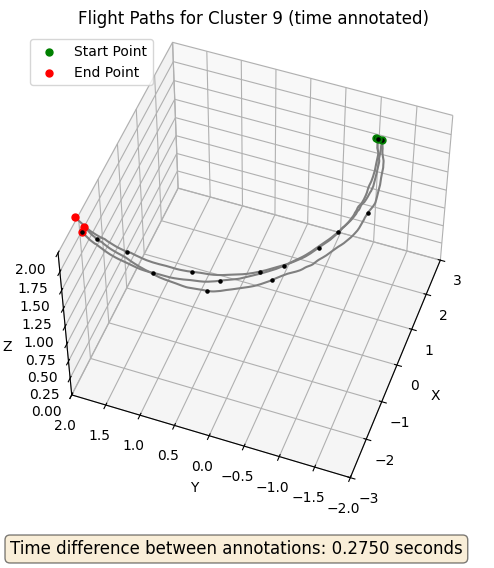

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming `session` is already defined and contains the flight data
all_clusters = sorted([int(cluster_id) for cluster_id in session.flights_by_cluster.keys() if int(cluster_id) != 1])

# Function to calculate Euclidean distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Loop through each cluster and create a separate plot
for cluster_idx, cluster_id in enumerate(all_clusters):
    cluster_flights = session.get_flights_by_cluster([cluster_id])

    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')

    for flight_idx, flight in enumerate(cluster_flights):
        start_idx, end_idx = flight.timebin_start_idx, flight.timebin_end_idx
        
        # flight_pos stores the XYZ coordinates of the flight positions between start_idx and end_idx.
        # Each row in flight_pos represents the coordinates at a specific time point.
        # flight_pos[i, 0], flight_pos[i, 1], flight_pos[i, 2] represent the X, Y, Z coordinates of the flight at the i-th time point, respectively.
        flight_pos = pos[start_idx:end_idx]

        if flight_pos.size == 0:
            continue  # Skip if there are no positions

        ax.plot(flight_pos[:, 0], flight_pos[:, 1], flight_pos[:, 2], color=colors[cluster_idx % len(colors)])

        # Mark the start and end points with different colors
        ax.scatter(flight_pos[0, 0], flight_pos[0, 1], flight_pos[0, 2], color='green', marker='.', s=100, label='Start Point' if flight_idx == 0 else "")
        ax.scatter(flight_pos[-1, 0], flight_pos[-1, 1], flight_pos[-1, 2], color='red', marker='.', s=100, label='End Point' if flight_idx == 0 else "")

        # Calculate the interval for annotations
        interval = max(1, len(flight_pos) // 10)  # Adjust the number of annotations as needed
        time_difference = interval * 0.008333333333333  # Time difference in seconds

        previous_annotation = None
        for i in range(0, len(flight_pos) - 10, interval):
            if previous_annotation is None or distance(flight_pos[i], previous_annotation) > 1:  # Adjust the distance threshold as needed
                ax.scatter(flight_pos[i, 0], flight_pos[i, 1], flight_pos[i, 2], color='black', marker='.')  # Change annotation color here
                previous_annotation = flight_pos[i]

    # Setting labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Flight Paths for Cluster {cluster_id} (time annotated)')

    # Set consistent limits for the axes
    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 2)

    # Add text box for time difference annotation
    textstr = f'Time difference between annotations: {time_difference:.4f} seconds'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig.text(0.5, 0.01, textstr, ha='center', fontsize=12, bbox=props)  # Adjust the position of the text

    # Add legend
    ax.legend(loc='upper left')
    
    ax.view_init(elev=50, azim=-160)  

    plt.show()


For neural data, you can access data via:

In [ ]:
session.spike_data.__dict__.keys()

In [ ]:
session.spike_data.num_cells_per_probe

In [ ]:
single_units = session.spike_data.all_single_units # List of all single units
single_units[13] # Cell # 13. Depth is measured from tip of probe (small number = deeper = probably CA3, larger number = probably CA1)

# single_units['spikeTimes_sec'] contains the spike times of the cell.

In [ ]:
# Can estimate the instantaneous firing rate of each cell via:
dt = 0.01 # Timescale you are interested in
spks, spks_timebin_edges = session.spike_data.estimate_firing_rates(dt, zscore=True, smooth=True, sigma_sec=0.05) # Optional to zscore or to smooth the estimated firing rate

## Data synchronization

As each data stream is recorded independently, it is crucial to synchronize the timestamps of each data stream as no 2 clocks are the same. We accomplish this by having each data stream record TTL pulses from a single source. Based on the TTL timings we can adjust the timestamps of each data sample into a commmon clock. I call this the global_timestamps. The global_timestamps calculations have already been done, so you can simply access it.

What you might need to do is resample the datastreams (based on the global timestamps) to match each other. A common use case is binning spikes times into fixed timebins, then binning the behavioral data into the same timebins so that you have a one-to-one matching of neural data and behavioral data at every timebin. I included a helper function for this you may find useful.

In [ ]:
from helpers_bat import label_timebins